# Constrained Simulation Examples

In [19]:
from typing import Sequence
import coba
from coba.random      import CobaRandom
from coba.simulations import LambdaSimulation, ConstrainedSimulation, Context, Action
from coba.learners    import RandomLearner, VowpalLearner, ChanceConstrainedOptimizer, EpsilonBanditLearner
from coba.benchmarks  import Benchmark
import numpy as np

In [28]:
n_interactions = 5000
r = CobaRandom()

Below is a constrained simulation with two possible actions- the higher reward action violates the constraint wile the lower reward action doesn't

In [61]:
def context(index: int) -> Context:
    return tuple(r.randoms(5))

def actions(index: int, context: Context) -> Sequence[Action]:
    return [1, 2]
    #actions = [ r.randoms(5) for _ in range(3) ]
    #return [ tuple(a/sum(action) for a in action) for action in actions ]

def rewards(index: int, context: Context, action: Action) -> float:
    if action == 1:
        return 0.5
    else:
        return 0.9

def feedback(index: int, context: Context, action: Action) -> Sequence[float]:
    if action == 1:
        return tuple((0.5, -1))
    return tuple((0.9, 0.8))

In [77]:
sim = [ConstrainedSimulation(n_interactions, context, actions, feedback)]

result = Benchmark(sim, shuffle=[1,2,3,4]).evaluate([ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=VowpalLearner, vw_kwargs={"bag":5, "seed":10}), 
                         ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=RandomLearner)])

2021-08-06 16:11:41 Processing chunk...
2021-08-06 16:11:41   * Creating source 0 from "ConstrainedSimulation"... (0.0 seconds) (completed)
2021-08-06 16:11:41   * Creating simulation 0 from source 0... (0.01 seconds) (completed)
2021-08-06 16:11:43   * Evaluating learner 0 on Simulation 0... (1.87 seconds) (completed)
2021-08-06 16:11:44   * Evaluating learner 1 on Simulation 0... (0.68 seconds) (completed)
2021-08-06 16:11:44   * Creating simulation 1 from source 0... (0.01 seconds) (completed)
2021-08-06 16:11:46   * Evaluating learner 0 on Simulation 1... (1.9 seconds) (completed)
2021-08-06 16:11:46   * Evaluating learner 1 on Simulation 1... (0.6 seconds) (completed)
2021-08-06 16:11:46   * Creating simulation 2 from source 0... (0.01 seconds) (completed)
2021-08-06 16:11:48   * Evaluating learner 0 on Simulation 2... (1.83 seconds) (completed)
2021-08-06 16:11:49   * Evaluating learner 1 on Simulation 2... (0.6 seconds) (completed)
2021-08-06 16:11:49   * Creating simulation 3 f

These results are averaged over 4 runs. We can see that the vw learner is obeying the constraint and as the number of iteractions increase, the standard deviation of the reward (denoted by the orange bars) decreases. I interpreted this as the vw learner seems to be consistently learning the constraint with the amount of time it takes to learn it varying.

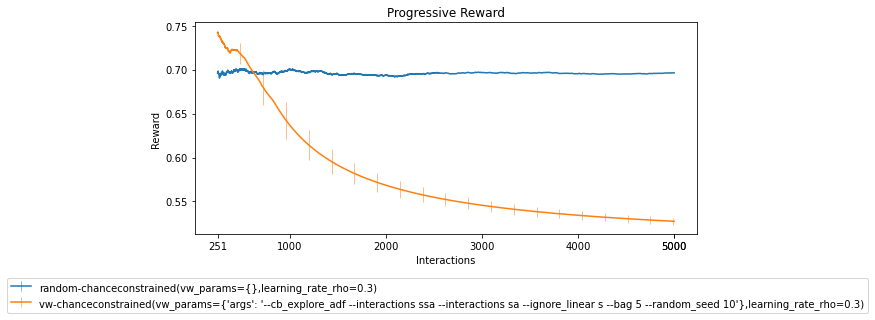

In [78]:
result.plot_learners()

This is a plot showing the reward averaged over every 10 interactions (I tried plotting instantaneous reward but it's a messy hard to interpret plot). Here we can see the vw learner reward dropping off and staying at 0.5.

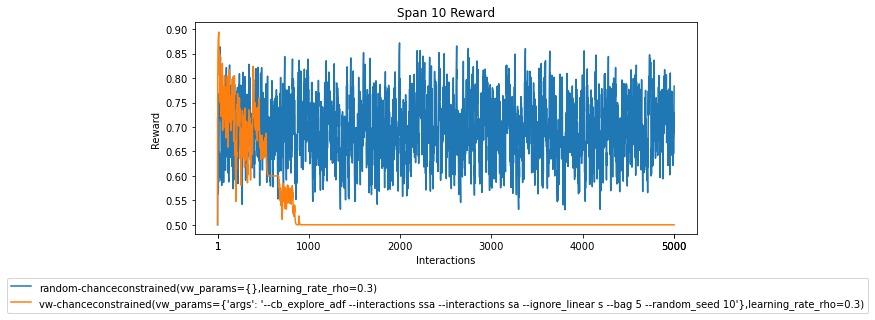

In [79]:
result.plot_learners(start=0.0, end=1.0, span=10 , err_every=0)

The simulation below is the same as the one above but with Gaussian noise added. This means that in some rare situations, the high reward action may not violate the constraint. I was interested in seeing how this would affect how quickly the vw learner learned the constraint and its effect on reward. This simulation was also an average of 4 runs.

In [80]:
def noisy_feedback(index: int, context: Context, action: Action) -> Sequence[float]:
    noise = np.random.normal()
    if action == 1:
        return tuple((0.5, -1+noise))
    return tuple((0.9, 0.8+noise))

In [81]:
sim = [ConstrainedSimulation(n_interactions, context, actions, noisy_feedback)]

noisy_result = Benchmark(sim, shuffle=[1,2,3,4]).evaluate([ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=VowpalLearner, vw_kwargs={"bag":5, "seed":10}), 
                         ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=RandomLearner)])

2021-08-06 16:17:07 Processing chunk...
2021-08-06 16:17:07   * Creating source 0 from "ConstrainedSimulation"... (0.0 seconds) (completed)
2021-08-06 16:17:07   * Creating simulation 0 from source 0... (0.01 seconds) (completed)
2021-08-06 16:17:09   * Evaluating learner 0 on Simulation 0... (1.85 seconds) (completed)
2021-08-06 16:17:10   * Evaluating learner 1 on Simulation 0... (0.64 seconds) (completed)
2021-08-06 16:17:10   * Creating simulation 1 from source 0... (0.01 seconds) (completed)
2021-08-06 16:17:12   * Evaluating learner 0 on Simulation 1... (1.82 seconds) (completed)
2021-08-06 16:17:12   * Evaluating learner 1 on Simulation 1... (0.58 seconds) (completed)
2021-08-06 16:17:12   * Creating simulation 2 from source 0... (0.01 seconds) (completed)
2021-08-06 16:17:14   * Evaluating learner 0 on Simulation 2... (1.84 seconds) (completed)
2021-08-06 16:17:15   * Evaluating learner 1 on Simulation 2... (0.55 seconds) (completed)
2021-08-06 16:17:15   * Creating simulation 

It seems like even with the noise, the vw learner tends towards the lower reward non-constraint violating action.

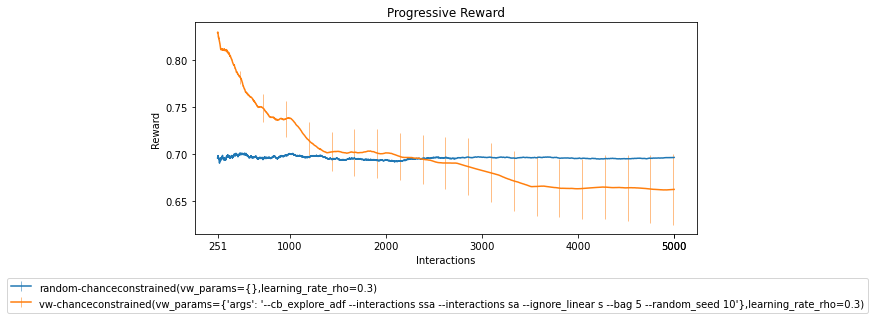

In [82]:
noisy_result.plot_learners()

This plot is hard to interpret given the noise, but it shows the general trend?

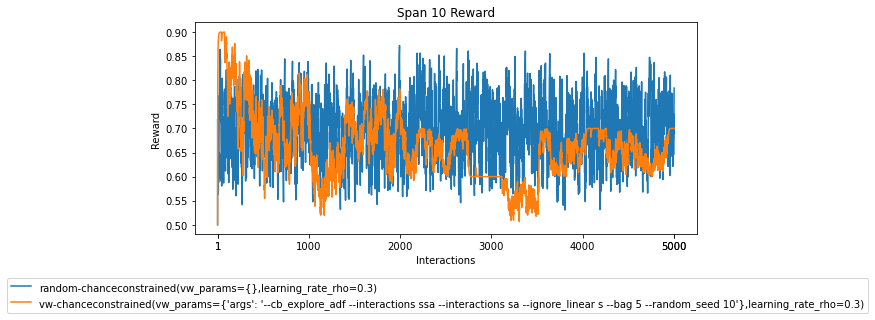

In [85]:
noisy_result.plot_learners(start=0.0, end=1.0, span=10 , err_every=0)

Finally I tested this on multiple actions and multiple constraints. The lowest reward action doesn't violate either constraint, the medium reward action violates one constraint and the ighest reward action violates both constraints.

In [51]:
def multiple_actions(index: int, context: Context) -> Sequence[Action]:
    return [1, 2, 3]
    #actions = [ r.randoms(5) for _ in range(3) ]
    #return [ tuple(a/sum(action) for a in action) for action in actions ]

def multiple_rewards(index: int, context: Context, action: Action) -> float:
    if action == 1:
        return 0.2
    if action == 2:
        return 0.6
    if action == 3:
        return 0.9

def multiple_feedback(index: int, context: Context, action: Action) -> Sequence[float]:
    if action == 1:
        return tuple((0.2, -1, -0.5))
    if action == 2:
        return tuple((0.6, -0.5, 0.8))
    if action == 3:
        return tuple((0.9, 0.7, 1))

In [97]:
sim = [ConstrainedSimulation(n_interactions, context, multiple_actions, multiple_feedback)]

multiple_result = Benchmark(sim).evaluate([ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=VowpalLearner, vw_kwargs={"bag":5, "seed":10}), 
                         ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=RandomLearner),
                        ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=EpsilonBanditLearner, vw_kwargs={"epsilon":0.1})])

2021-08-06 16:28:54 Processing chunk...
2021-08-06 16:28:54   * Creating source 0 from "ConstrainedSimulation"... (0.0 seconds) (completed)
2021-08-06 16:28:54   * Creating simulation 0 from source 0... (0.0 seconds) (completed)
2021-08-06 16:28:56   * Evaluating learner 0 on Simulation 0... (2.13 seconds) (completed)
2021-08-06 16:28:57   * Evaluating learner 1 on Simulation 0... (0.61 seconds) (completed)
2021-08-06 16:28:57   * Evaluating learner 2 on Simulation 0... (0.73 seconds) (completed)


I also included the epsilon bandit learner with constraint because I was curious but it doesn't seem to be learning the constraint to well compared to the vw learner (is this learner reasonable for this type of simulation?). We can see though that the vw learner quickly goes for the lowest reward non constraint violating option.

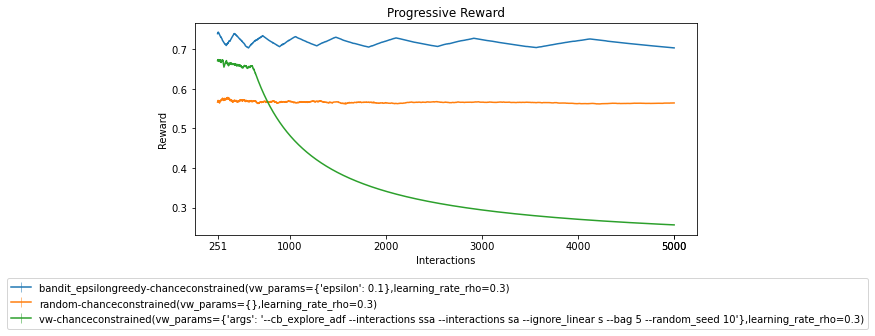

In [98]:
multiple_result.plot_learners()

And here's a span 10 simulation again where you can see that remarkable drop off.

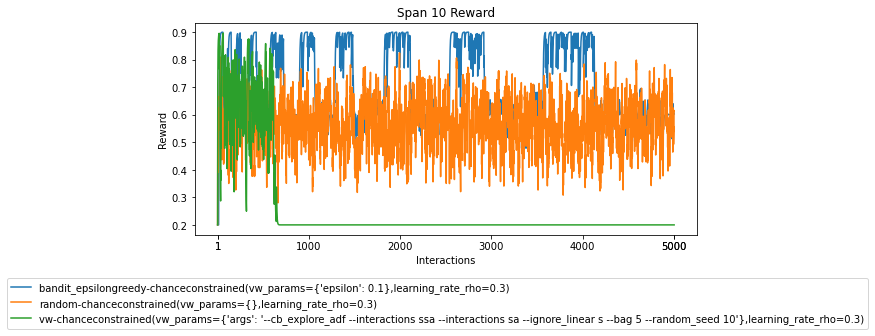

In [99]:
multiple_result.plot_learners(start=0.0, end=1.0, span=10 , err_every=0)